# Notebook for testing and debugging Sequential Monte Carlo algorithms

In [2]:
%load_ext autoreload
%autoreload 2
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from time import time
from tqdm import tqdm
from collections import defaultdict
from math import ceil
import seaborn as sns

from approxmh.utilities import *
from approxmh.samplers import *
from approxmh.distributions import Banana, Funnel, create_gaussian_mixture, create_gaussian_lattice, create_random_gaussian_mixture, get_mode_coverage
from approxmh.distribution_metrics import *
from approxmh.sequential_mcmc import LangevinKernel, run_annealed_importance_sampling, ais_langevin_log_norm_constant_ratio, DensityMixture

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


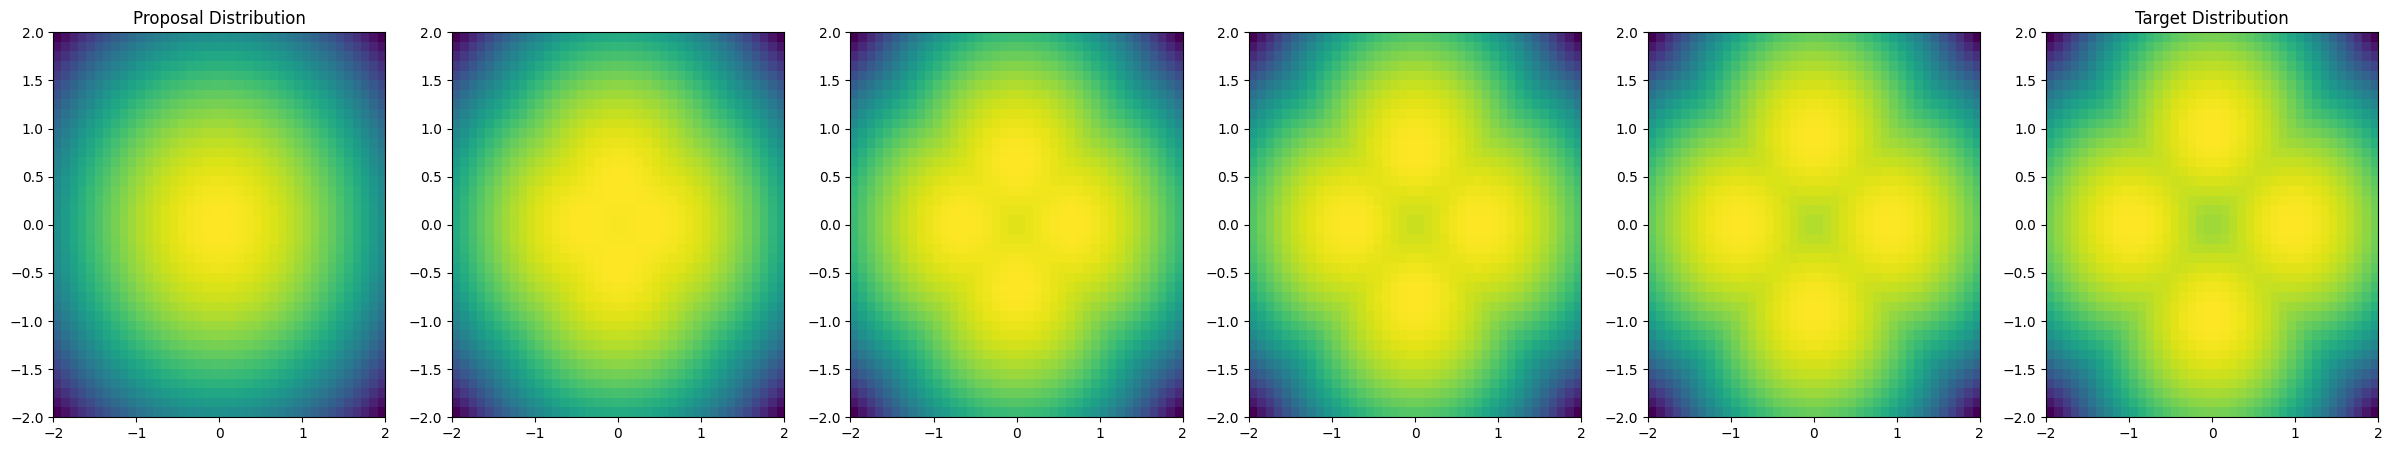

In [3]:
D = 2
proposal = torch.distributions.MultivariateNormal(torch.tensor([0., 0.]), 0.3 * torch.eye(D))
target = create_gaussian_mixture(
    means = torch.tensor([[-1., 0.], [1., 0.], [0., -1.], [0., 1.]]),
    cov_matricies = 0.1 * torch.eye(2)
)

n_steps = 5
beta = torch.linspace(0, 1, n_steps + 1)

xlim=(-2, 2)
ylim = (-2, 2)
d = 40

fig, axs = plt.subplots(ncols=n_steps+1, figsize=(5*(n_steps+1), 5))
img1 = plot_2d_torch_function(axs[0], proposal.log_prob, xlim, ylim, d)
axs[0].set_title('Proposal Distribution')
img2 = plot_2d_torch_function(axs[-1], target.log_prob, xlim, ylim, d)
axs[-1].set_title('Target Distribution')
vmin1, vmax1 = img1.get_clim()
vmin2, vmax2 = img2.get_clim()
clim = (min(vmin1, vmin2), max(vmax1, vmax2))
img1.set_clim(*clim)
img2.set_clim(*clim)

for t in range(0, n_steps + 1):
    img = plot_2d_torch_function(axs[t], DensityMixture(proposal, 1 - beta[t], target, beta[t]).log_prob, xlim, ylim, d)
    #img.set_clim(*clim)

Weight Mean : 0.991781
Weight Variance : 0.264820


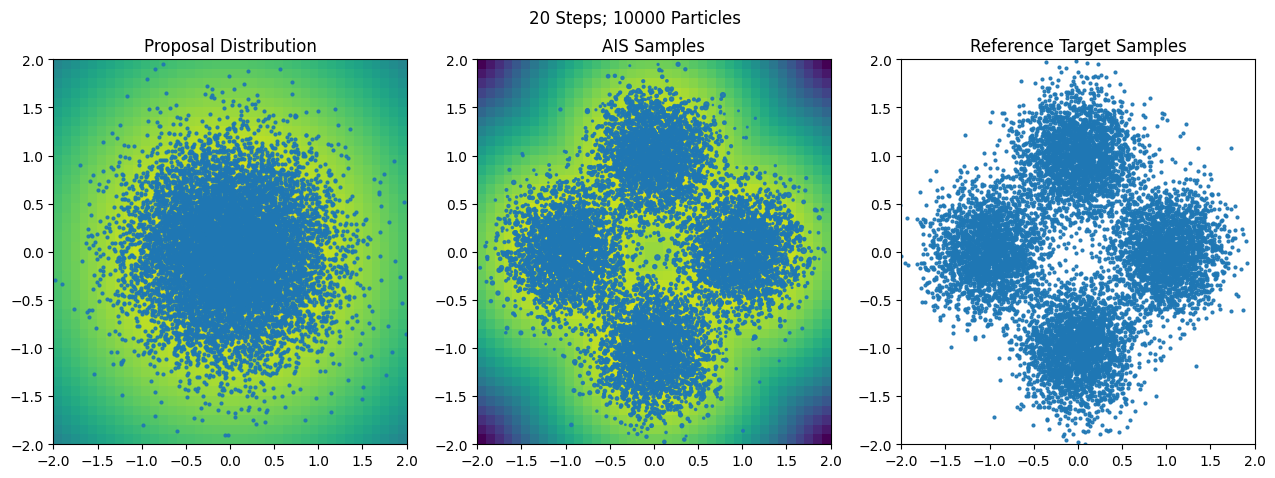

In [3]:
# ULA parameters
time_step = 0.132
# AIS parameters
n_steps = 20
n_particles = 10000
mh_corrected = True
transition_kernel = lambda distr: LangevinKernel(distr, time_step, mh_corrected=mh_corrected)

log_weights, ais_samples = run_annealed_importance_sampling(
    proposal, target, n_steps, 
    n_particles, transition_kernel,
    kernel_type='invariant' if mh_corrected else 'almost_invertible',
    resample=False
)

fig, axs = plt.subplots(ncols=3, figsize=(15.5, 5))
marker_s = 4
marker_alpha = 0.9

img1 = plot_2d_torch_function(axs[0], proposal.log_prob, xlim, ylim, d)
axs[0].scatter(*pl(proposal.sample((n_particles,))), s=marker_s, alpha=marker_alpha)
axs[0].set_title('Proposal Distribution')

img2 = plot_2d_torch_function(axs[1], target.log_prob, xlim, ylim, d)
axs[1].scatter(*pl(ais_samples), s=marker_s*log_weights.detach().exp().cpu(), alpha=marker_alpha)
axs[1].set_title('AIS Samples')

axs[2].scatter(*pl(target.sample((n_particles,))), s=marker_s, alpha=marker_alpha)
axs[2].set_title('Reference Target Samples')

for ax in axs:
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

vmin1, vmax1 = img1.get_clim()
vmin2, vmax2 = img2.get_clim()
clim = (min(vmin1, vmin2), max(vmax1, vmax2))
img1.set_clim(*clim)
img2.set_clim(*clim)

fig.suptitle(f'{n_steps} Steps; {n_particles} Particles')

average_weight = log_weights.exp().sum() / n_particles
weight_variance = torch.var(log_weights.exp())
print(f'Weight Mean : {average_weight:0.6f}')
print(f'Weight Variance : {weight_variance:0.6f}')

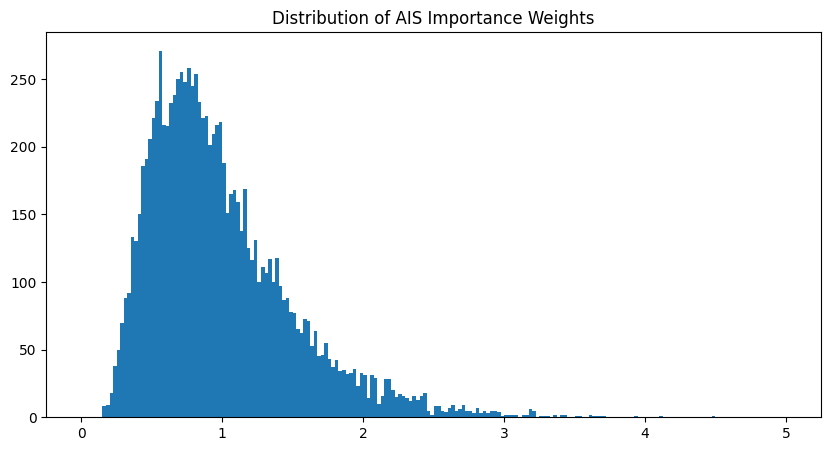

In [4]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.hist(to_numpy(log_weights.exp()), bins=200, range=(0, 5))
ax.set_title('Distribution of AIS Importance Weights');

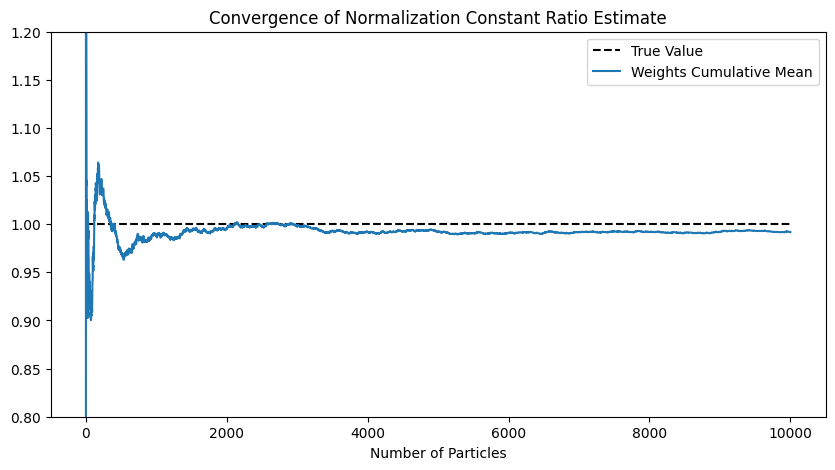

In [5]:
n_range = torch.arange(1, n_particles + 1)
weights_cummean = log_weights.exp().cumsum(dim=0) / n_range
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.hlines(1, 1, n_particles, linestyle='--', color='black', label='True Value')
ax.plot(n_range, weights_cummean, label='Weights Cumulative Mean')
ax.set_ylim(0.8, 1.2)
ax.set_xlabel('Number of Particles')
ax.legend()
ax.set_title('Convergence of Normalization Constant Ratio Estimate');

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [01:54<00:00,  1.74it/s]


Time step for optimal ULA variance: 0.31623
Minimal ULA variance: 0.00003
Time step for optimal MALA variance: 0.13277
Minimal MALA variance: 0.26348


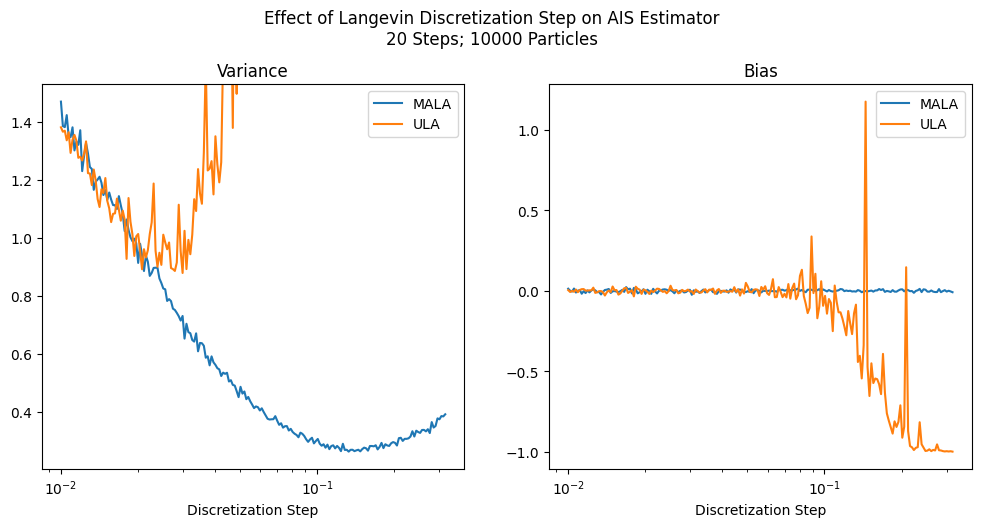

In [73]:
# ULA parameters
time_step_options = np.logspace(-2, -0.5, 200)
# AIS parameters
n_steps = 20
n_particles = 10_000

test_logs = defaultdict(list)
for time_step in tqdm(time_step_options):
    for kernel_name, mh_corrected in zip(['ula', 'mala'], [False, True]):
        log_mean, variance = ais_langevin_log_norm_constant_ratio(
            proposal, target, n_steps=n_steps, n_particles=n_particles, 
            time_step=time_step, mh_corrected=mh_corrected, return_variance=True
        )
        test_logs[kernel_name + '_variance'].append(variance)
        test_logs[kernel_name + '_bias'].append(log_mean.exp() - 1)

fig, axs = plt.subplots(figsize=(12, 5), ncols=2)
fig.suptitle(f'Effect of Langevin Discretization Step on AIS Estimator\n{n_steps} Steps; {n_particles} Particles', y=1.03)

ax = axs[0]
ax.set_title('Variance')
ax.plot(time_step_options, test_logs['mala_variance'], label='MALA')
fylim = ax.get_ylim()
ax.plot(time_step_options[:-50], test_logs['ula_variance'][:-50], label='ULA')
ax.set_ylim(*fylim)

ax = axs[1]
ax.set_title('Bias')
ax.plot(time_step_options, test_logs['mala_bias'], label='MALA')
ax.plot(time_step_options, test_logs['ula_bias'], label='ULA')

for ax in axs:
    ax.set_xlabel('Discretization Step')
    ax.set_xscale('log')
    ax.legend()

for kernel_name in ['ula', 'mala']:
    best_i = np.argmin(test_logs[kernel_name + '_variance'])
    best_time_step = time_step_options[best_i]
    min_variance = test_logs[kernel_name + '_variance'][best_i]
    print(f'Time step for optimal {kernel_name.upper()} variance: {best_time_step:0.5f}')
    print(f'Minimal {kernel_name.upper()} variance: {min_variance:0.5f}')

True
Log prob gradients standard deviation: tensor([0.0010, 1.0175])
Log prob standard deviation: tensor(0.9887, grad_fn=<StdBackward0>)


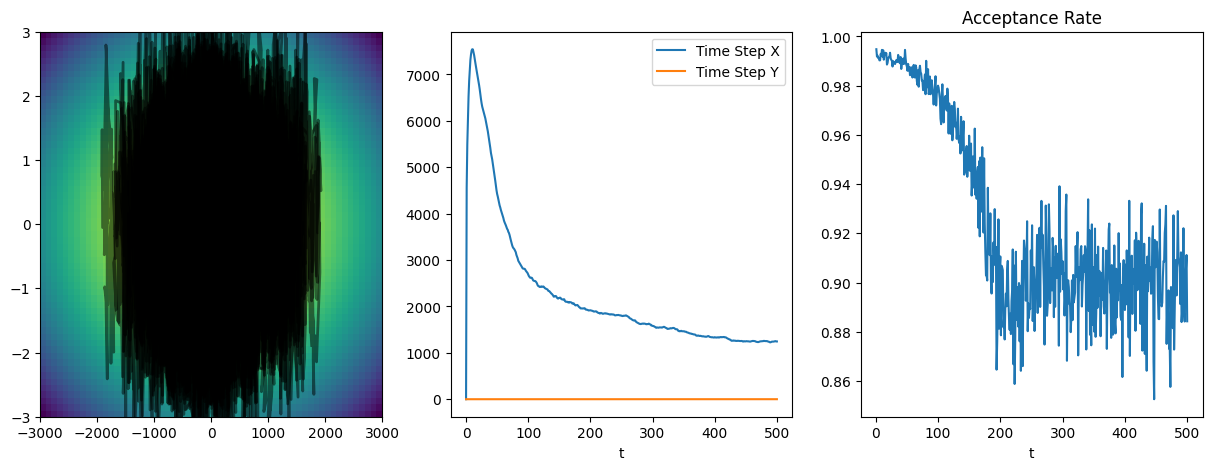

In [15]:
def conditioned_langevin_test():
    n_particles = 100
    n_steps=500
    dpi=60
    xscale = 1000.
    gamma = 0.1
    acc_rate_target = 0.9
    time_step=torch.tensor([1., 1.]) * gamma
    xlim = (-3 * xscale, 3 * xscale)
    ylim = (-3, 3)

    proposal = torch.distributions.MultivariateNormal(torch.tensor([0., 0.]), torch.diag(torch.tensor([1., 1.])))
    target = torch.distributions.MultivariateNormal(torch.tensor([0., 0.]), torch.diag(torch.tensor([xscale**2, 1.])))
    
    x = torch.zeros((n_particles, 2))
    xs = [x.detach()]
    time_steps = [time_step]
    acc_rates = []
    
    for i in range(n_steps):
        kernel = LangevinKernel(target, time_step=time_step, mh_corrected=True)
        x, acc_prob = kernel.step(x)
        acc_rate = acc_prob.mean().item()
        if acc_rate < acc_rate_target:
            gamma *= 0.99
        else:
            gamma *= 1.01

        x.requires_grad_(True)
        log_prob_grads = torch.autograd.grad(target.log_prob(x).sum(), x)[0]
        grads_std = torch.std(log_prob_grads, axis=0)
        time_step = 0.95 * time_step + 0.05 * gamma / (1e-5 + grads_std)
        
        xs.append(x.detach())
        time_steps.append(time_step.detach())
        acc_rates.append(acc_rate)

    xs = torch.stack(xs, dim=1).requires_grad_(True)
    time_steps = to_numpy(torch.stack(time_steps, dim=0))

    fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

    ax = axs[0]
    plot_2d_torch_function(ax, target.log_prob, xlim, ylim, dpi)
    for i in range(n_particles):
        ax.plot(*pl(xs[i]), c='black', alpha=0.5, linewidth=2)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax = axs[1]
    ax.plot(np.arange(n_steps+1), time_steps[:, 0] / time_steps[:, 1], label='Time Step X')
    ax.plot(np.arange(n_steps+1), time_steps[:, 1], label='Time Step Y')
    ax.set_xlabel('t')
    ax.legend()

    ax = axs[2]
    ax.set_title('Acceptance Rate')
    ax.plot(np.arange(1, n_steps+1), acc_rates)
    ax.set_xlabel('t')

    target_xs = target.sample((n_steps,)).requires_grad_(True)
    log_probs = target.log_prob(target_xs)
    print(xs.requires_grad)
    log_prob_grads = torch.autograd.grad(log_probs.sum(), target_xs)[0]
    print('Log prob gradients standard deviation:', torch.std(log_prob_grads, axis=0))
    print('Log prob standard deviation:', torch.std(log_probs, axis=0))

conditioned_langevin_test()